In [9]:
import os
print("CWD:", os.getcwd())


CWD: C:\Users\shravya\Downloads\archive (14)\final dataset used for oil spill\dataset-final\dataset


In [1]:
ok = True
try:
    import torch, torchvision
    import sklearn
    from PIL import Image
    import matplotlib
    print("torch:", torch.__version__, "| torchvision:", torchvision.__version__)
    print("sklearn:", sklearn.__version__)
    print("Pillow:", Image.__version__)
    print("matplotlib:", matplotlib.__version__)
except Exception as e:
    ok = False
    print("Missing or broken package:", e)

print("All good?" , ok)


torch: 2.5.1 | torchvision: 0.20.1
sklearn: 1.7.1
Pillow: 11.1.0
matplotlib: 3.10.5
All good? True


In [3]:
import os, random, math, numpy as np
from pathlib import Path
from PIL import Image

import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_recall_fscore_support

# ---- force CPU (no GPU needed) ----
device = torch.device("cpu")
torch.manual_seed(42); np.random.seed(42); random.seed(42)
print("Using device:", device)

# ---- EDIT THIS if your path is different ----
DATA_ROOT = Path(r"C:\Users\shravya\Downloads\archive (14)\final dataset used for oil spill\dataset-final\dataset")
assert DATA_ROOT.exists(), f"DATA_ROOT not found: {DATA_ROOT}"

VAL_DIR = DATA_ROOT / "Validation" if (DATA_ROOT / "Validation").exists() else DATA_ROOT / "val"
print("train:", (DATA_ROOT/"train").exists(), "  val:", VAL_DIR.exists(), "  test:", (DATA_ROOT/"test").exists())

# peek classes
_tmp = datasets.ImageFolder(str(DATA_ROOT/"train"))
print("Classes:", _tmp.classes)


Using device: cpu
train: True   val: True   test: True
Classes: ['Non Oil Spill', 'Oil Spill']


In [5]:
# quick stats so normalization is sane, but fast for CPU
train_dir = DATA_ROOT / "train"
ex = (".jpg",".jpeg",".png",".bmp",".tif",".tiff")
files = [p for p in train_dir.rglob("*") if p.suffix.lower() in ex]

sample_n = min(256, len(files))
sampled = random.sample(files, sample_n)

sum_mean = np.zeros(3, dtype=np.float64)
sum_sqmn = np.zeros(3, dtype=np.float64)

for fp in sampled:
    img = Image.open(fp).convert("RGB").resize((256,256))
    arr = np.asarray(img, dtype=np.float32) / 255.0      # H×W×3 in [0,1]
    flat = arr.reshape(-1, 3)
    m = flat.mean(axis=0)
    sq = (flat**2).mean(axis=0)
    sum_mean += m
    sum_sqmn += sq

ds_mean = (sum_mean / sample_n).tolist()
var = (sum_sqmn / sample_n) - np.array(ds_mean)**2
ds_std = np.sqrt(np.clip(var, 1e-8, None)).tolist()

print("Estimated mean/std:", ds_mean, ds_std)


Estimated mean/std: [0.5081257043057121, 0.5861610320280306, 0.6270033112959936] [0.3083531148448047, 0.2741076234785722, 0.27973077980500083]


In [21]:
class SmallOilCNN(nn.Module):
    def __init__(self):
        super().__init__()
        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            )
        self.features = nn.Sequential(
            block(3, 32),   # 256 -> 128
            block(32, 64),  # 128 -> 64
            block(64, 128), # 64  -> 32
        )
        self.pool = nn.AdaptiveAvgPool2d(1)  # (B,128,1,1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(128, 1)  # binary logit
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.head(x)
        return x  # logits (no sigmoid here)

model = SmallOilCNN().to(device)
sum(p.numel() for p in model.parameters())/1e6


0.288033

In [7]:
train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((288, 288)),
    transforms.RandomResizedCrop(256, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(ds_mean, ds_std),
])

val_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(ds_mean, ds_std),
])

train_ds = datasets.ImageFolder(str(DATA_ROOT/"train"), transform=train_tfms)
val_ds   = datasets.ImageFolder(str(VAL_DIR),           transform=val_tfms)
test_ds  = datasets.ImageFolder(str(DATA_ROOT/"test"),  transform=val_tfms) if (DATA_ROOT/"test").exists() else None

# Windows note: num_workers=0 or 2; pin_memory=False for CPU
BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=False) if test_ds else None

print("sizes → train/val/test:", len(train_ds), len(val_ds), len(test_ds) if test_ds else 0)


sizes → train/val/test: 2800 600 600


In [9]:
class BasicBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_c)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_c)
        self.down  = nn.Sequential()
        if stride != 1 or in_c != out_c:
            self.down = nn.Sequential(
                nn.Conv2d(in_c, out_c, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_c)
            )
    def forward(self, x):
        identity = self.down(x) if len(self.down) else x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class ResNetTiny(nn.Module):
    """smaller channels for CPU: 16→32→64"""
    def __init__(self, in_ch=3):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, 16, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(16), nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1)    # 256->64
        )
        self.layer1 = nn.Sequential(BasicBlock(16, 32), BasicBlock(32, 32))
        self.layer2 = nn.Sequential(BasicBlock(32, 64, stride=2), BasicBlock(64,64))  # 64->32
        self.pool   = nn.AdaptiveAvgPool2d(1)
        self.fc     = nn.Linear(64, 1)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x); x = self.layer2(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)

model = ResNetTiny().to(device)
print("Params (M):", round(sum(p.numel() for p in model.parameters())/1e6, 3))


Params (M): 0.167


In [11]:
targs = np.array(train_ds.targets)
pos = int((targs == 1).sum()); neg = int((targs == 0).sum())
pos_weight = torch.tensor([neg / max(1, pos)], device=device, dtype=torch.float32)
print(f"counts → NonOil={neg}, Oil={pos}, pos_weight={pos_weight.item():.3f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=12)  # simple & CPU-light

EPOCHS = 18   # start small; you can bump to 25–30 later


counts → NonOil=1400, Oil=1400, pos_weight=1.000


In [13]:
def run_epoch(loader, train_mode=True):
    model.train(train_mode)
    total_loss, correct, total = 0.0, 0, 0
    all_probs, all_labels = [], []

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        logits = model(imgs)
        loss = criterion(logits, labels)

        if train_mode:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        probs = torch.sigmoid(logits).detach()
        preds = (probs >= 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += imgs.size(0)

        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    avg_loss = total_loss / total
    acc = correct / total
    all_probs = np.vstack(all_probs).ravel()
    all_labels = np.vstack(all_labels).ravel()
    return avg_loss, acc, all_probs, all_labels

best_f1, best_state, best_thr = 0.0, None, 0.5

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, _, _ = run_epoch(train_loader, True)
    va_loss, va_acc, va_probs, va_labels = run_epoch(val_loader, False)
    scheduler.step()

    # fast threshold sweep (CPU-friendly)
    thrs = np.linspace(0.3, 0.7, 21)
    f1s  = [f1_score(va_labels, (va_probs>=t).astype(int), zero_division=0) for t in thrs]
    t_star = thrs[int(np.argmax(f1s))]
    va_preds = (va_probs >= t_star).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(va_labels, va_preds, average="binary", zero_division=0)

    print(f"Epoch {epoch:02d} | train {tr_loss:.4f}/{tr_acc:.3f} | "
          f"val {va_loss:.4f}/{va_acc:.3f} | F1 {f1:.3f} (thr={t_star:.2f}) P {p:.3f} R {r:.3f}")

    if f1 > best_f1:
        best_f1, best_thr = f1, t_star
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        os.makedirs("models", exist_ok=True)
        torch.save({"state": best_state, "thr": best_thr, "mean": ds_mean, "std": ds_std},
                   "models/best_cpu_resnettiny_oilspill.pth")

print("Best val F1:", round(best_f1, 3), "at thr", round(best_thr, 2))


Epoch 01 | train 0.6187/0.652 | val 0.6836/0.642 | F1 0.628 (thr=0.30) P 0.550 R 0.730
Epoch 02 | train 0.5714/0.697 | val 0.8502/0.572 | F1 0.543 (thr=0.30) P 0.756 R 0.423
Epoch 03 | train 0.5408/0.728 | val 0.7060/0.673 | F1 0.661 (thr=0.32) P 0.680 R 0.643
Epoch 04 | train 0.5032/0.764 | val 0.8581/0.702 | F1 0.654 (thr=0.30) P 0.662 R 0.647
Epoch 05 | train 0.4749/0.780 | val 0.6729/0.718 | F1 0.691 (thr=0.30) P 0.725 R 0.660
Epoch 06 | train 0.4540/0.791 | val 0.8947/0.697 | F1 0.660 (thr=0.30) P 0.804 R 0.560
Epoch 07 | train 0.4277/0.812 | val 0.7169/0.727 | F1 0.694 (thr=0.32) P 0.754 R 0.643
Epoch 08 | train 0.4097/0.816 | val 0.6125/0.750 | F1 0.741 (thr=0.32) P 0.819 R 0.677
Epoch 09 | train 0.3772/0.830 | val 0.5235/0.770 | F1 0.739 (thr=0.36) P 0.824 R 0.670
Epoch 10 | train 0.3650/0.840 | val 0.5399/0.758 | F1 0.743 (thr=0.34) P 0.792 R 0.700
Epoch 11 | train 0.3415/0.861 | val 0.4757/0.780 | F1 0.775 (thr=0.30) P 0.801 R 0.750
Epoch 12 | train 0.3355/0.856 | val 0.4761/

In [15]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, classification_report, confusion_matrix
import torch

# Load best
ckpt = torch.load("models/best_cpu_resnettiny_oilspill.pth", map_location="cpu")
model.load_state_dict(ckpt["state"])
best_thr = ckpt["thr"]

def predict_probs(loader):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            logits = model(imgs)
            probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())
    return np.concatenate(all_probs), np.concatenate(all_labels)

va_probs, va_labels = predict_probs(val_loader)

# 1a) Report at saved best-threshold (F1-optimized)
from sklearn.metrics import f1_score
preds_f1 = (va_probs >= best_thr).astype(int)
print(f"[F1-opt] thr={best_thr:.2f}  Acc={accuracy_score(va_labels, preds_f1):.3f}  F1={f1_score(va_labels, preds_f1):.3f}")
print(classification_report(va_labels, preds_f1, target_names=train_ds.classes, zero_division=0))
print("Confusion:\n", confusion_matrix(va_labels, preds_f1))

# 1b) Find threshold that maximizes ACCURACY (often higher acc, maybe lower F1)
ts = np.linspace(0.2, 0.9, 71)
accs = [accuracy_score(va_labels, (va_probs>=t).astype(int)) for t in ts]
t_acc = ts[int(np.argmax(accs))]
preds_acc = (va_probs >= t_acc).astype(int)
print(f"\n[ACC-opt] thr={t_acc:.2f}  Acc={accuracy_score(va_labels, preds_acc):.3f}  F1={f1_score(va_labels, preds_acc):.3f}")
print(classification_report(va_labels, preds_acc, target_names=train_ds.classes, zero_division=0))


C:\Users\shravya\AppData\Local\Temp\ipykernel_6824\3090445402.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("models/best_cpu_resnettiny_oilspill.pth"

[F1-opt] thr=0.32  Acc=0.800  F1=0.793
               precision    recall  f1-score   support

Non Oil Spill       0.78      0.83      0.81       300
    Oil Spill       0.82      0.77      0.79       300

     accuracy                           0.80       600
    macro avg       0.80      0.80      0.80       600
 weighted avg       0.80      0.80      0.80       600

Confusion:
 [[250  50]
 [ 70 230]]

[ACC-opt] thr=0.24  Acc=0.805  F1=0.813
               precision    recall  f1-score   support

Non Oil Spill       0.83      0.76      0.80       300
    Oil Spill       0.78      0.85      0.81       300

     accuracy                           0.81       600
    macro avg       0.81      0.80      0.80       600
 weighted avg       0.81      0.81      0.80       600



In [19]:
# === Fine-tune 10–12 more epochs (CPU) ===
import numpy as np, torch
from sklearn.metrics import f1_score, precision_recall_fscore_support

# load best so far
ckpt = torch.load("models/best_cpu_resnettiny_oilspill.pth", map_location="cpu")
model.load_state_dict(ckpt["state"])

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=12)
criterion = torch.nn.BCEWithLogitsLoss()  # balanced val → no pos_weight

def run_epoch(loader, train_mode=True):
    model.train(train_mode)
    tot, n = 0.0, 0
    allp, ally = [], []
    for x,y in loader:
        logits = model(x)
        loss = criterion(logits, y.float().unsqueeze(1))
        if train_mode:
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        tot += loss.item()*x.size(0); n += x.size(0)
        p = torch.sigmoid(logits).detach().squeeze(1).numpy()
        allp.append(p); ally.append(y.numpy())
    return tot/n, np.concatenate(allp), np.concatenate(ally)

best_f1 = 0.0
best_thr = 0.5

for ep in range(1, 13):
    tr_loss, _, _ = run_epoch(train_loader, True)
    va_loss, vp, vl = run_epoch(val_loader, False)
    ts = np.linspace(0.25, 0.75, 21)
    f1s = [f1_score(vl, (vp>=t).astype(int), zero_division=0) for t in ts]
    t_star = ts[int(np.argmax(f1s))]; f1 = float(np.max(f1s))
    p,r,f,_ = precision_recall_fscore_support(vl, (vp>=t_star).astype(int), average="binary", zero_division=0)
    print(f"FT {ep:02d} | val loss {va_loss:.4f} | F1 {f1:.3f} thr {t_star:.2f} (P {p:.3f}, R {r:.3f})")
    scheduler.step()

    if f1 > best_f1:
        best_f1, best_thr = f1, t_star
        os.makedirs("models", exist_ok=True)
        torch.save(
            {
                "state": {k: v.cpu() for k, v in model.state_dict().items()},
                "thr": best_thr,
                "mean": ds_mean,
                "std": ds_std,
            },
            "models/best_cpu_resnettiny_oilspill_finetuned.pth"
        )

print("Fine-tune best F1:", round(best_f1,3), "at thr", round(best_thr,2))


C:\Users\shravya\AppData\Local\Temp\ipykernel_6824\3378695895.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("models/best_cpu_resnettiny_oilspill.pth"

FT 01 | val loss 0.5314 | F1 0.766 thr 0.28 (P 0.805, R 0.730)
FT 02 | val loss 0.4150 | F1 0.816 thr 0.35 (P 0.797, R 0.837)
FT 03 | val loss 0.4942 | F1 0.756 thr 0.62 (P 0.850, R 0.680)
FT 04 | val loss 0.3768 | F1 0.841 thr 0.30 (P 0.782, R 0.910)
FT 05 | val loss 0.4575 | F1 0.801 thr 0.30 (P 0.785, R 0.817)
FT 06 | val loss 0.4597 | F1 0.797 thr 0.25 (P 0.818, R 0.777)
FT 07 | val loss 0.4311 | F1 0.822 thr 0.33 (P 0.828, R 0.817)
FT 08 | val loss 0.4444 | F1 0.815 thr 0.25 (P 0.821, R 0.810)
FT 09 | val loss 0.4924 | F1 0.817 thr 0.25 (P 0.866, R 0.773)
FT 10 | val loss 0.4524 | F1 0.841 thr 0.25 (P 0.904, R 0.787)
FT 11 | val loss 0.3417 | F1 0.859 thr 0.30 (P 0.845, R 0.873)
FT 12 | val loss 0.3727 | F1 0.854 thr 0.28 (P 0.869, R 0.840)
Fine-tune best F1: 0.859 at thr 0.3


In [21]:
import numpy as np, torch
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, roc_auc_score, classification_report, confusion_matrix

# load best fine-tuned
ckpt = torch.load("models/best_cpu_resnettiny_oilspill_finetuned.pth", map_location="cpu")
model.load_state_dict(ckpt["state"])
best_thr = float(ckpt["thr"])
print("Best threshold:", best_thr)

def predict_probs(loader):
    model.eval()
    all_p, all_y = [], []
    with torch.no_grad():
        for x,y in loader:
            logits = model(x)
            p = torch.sigmoid(logits).squeeze(1).numpy()
            all_p.append(p); all_y.append(y.numpy())
    return np.concatenate(all_p), np.concatenate(all_y)

def eval_split(loader, name="split", thr=0.5):
    probs, labels = predict_probs(loader)
    preds = (probs >= thr).astype(int)
    p,r,f,_ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, probs)
    print(f"\n{name} | Acc {acc:.3f}  F1 {f:.3f}  P {p:.3f}  R {r:.3f}  ROC-AUC {auc:.3f}  thr={thr:.2f}")
    print(classification_report(labels, preds, target_names=train_ds.classes, zero_division=0))
    print("Confusion:\n", confusion_matrix(labels, preds))
    return acc, f, p, r, auc

eval_split(val_loader,  "Validation", thr=best_thr)
if test_loader:
    eval_split(test_loader, "Test",        thr=best_thr)


C:\Users\shravya\AppData\Local\Temp\ipykernel_6824\3919699049.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("models/best_cpu_resnettiny_oilspill_fine

Best threshold: 0.3

Validation | Acc 0.857  F1 0.859  P 0.845  R 0.873  ROC-AUC 0.934  thr=0.30
               precision    recall  f1-score   support

Non Oil Spill       0.87      0.84      0.85       300
    Oil Spill       0.85      0.87      0.86       300

     accuracy                           0.86       600
    macro avg       0.86      0.86      0.86       600
 weighted avg       0.86      0.86      0.86       600

Confusion:
 [[252  48]
 [ 38 262]]

Test | Acc 0.900  F1 0.905  P 0.861  R 0.953  ROC-AUC 0.975  thr=0.30
               precision    recall  f1-score   support

Non Oil Spill       0.95      0.85      0.89       300
    Oil Spill       0.86      0.95      0.91       300

     accuracy                           0.90       600
    macro avg       0.90      0.90      0.90       600
 weighted avg       0.90      0.90      0.90       600

Confusion:
 [[254  46]
 [ 14 286]]


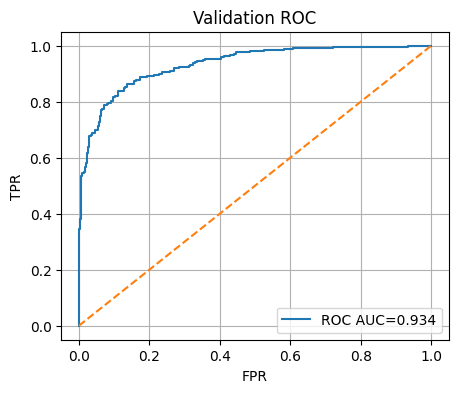

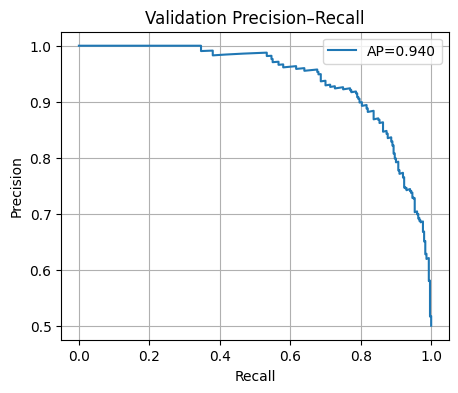

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

probs, labels = predict_probs(val_loader)

# ROC
fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Validation ROC"); plt.legend(); plt.grid(True); plt.show()

# PR
prec, rec, _ = precision_recall_curve(labels, probs)
ap = average_precision_score(labels, probs)

plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Validation Precision–Recall"); plt.legend(); plt.grid(True); plt.show()


C:\Users\shravya\AppData\Local\Temp\ipykernel_6824\2017639981.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("models/best_cpu_resnettiny_oilspill_fine

[OilSpill_00763.jpg]  pred=Oil Spill  p_oil=0.712  thr=0.30


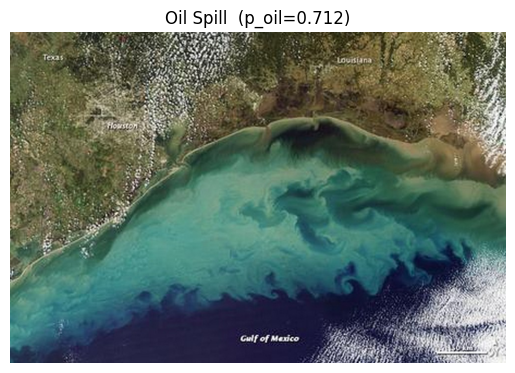

[OilSpill_00782.jpg]  pred=Oil Spill  p_oil=0.995  thr=0.30


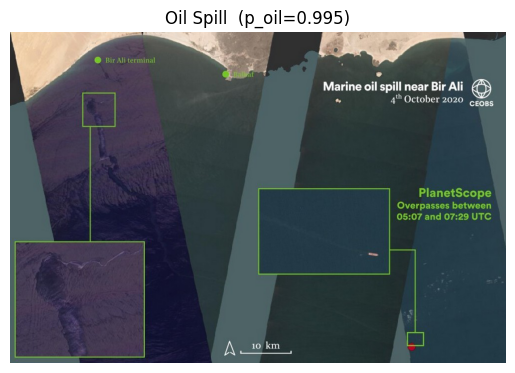

In [31]:
import random
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import torch

# 1) make sure best model is loaded
ckpt = torch.load("models/best_cpu_resnettiny_oilspill_finetuned.pth", map_location="cpu")
model.load_state_dict(ckpt["state"])
best_thr = float(ckpt["thr"])
model.eval()

# 2) helper (redefine in case you didn't run it)
infer_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(ds_mean, ds_std),
])
idx_to_class = {v:k for k,v in train_ds.class_to_idx.items()}

def predict_and_show(path, thr=best_thr):
    img = Image.open(path).convert("RGB")
    with torch.no_grad():
        p = torch.sigmoid(model(infer_tfms(img).unsqueeze(0))).item()
    pred = idx_to_class[int(p >= thr)]
    print(f"[{Path(path).name}]  pred={pred}  p_oil={p:.3f}  thr={thr:.2f}")
    plt.imshow(img); plt.title(f"{pred}  (p_oil={p:.3f})"); plt.axis("off"); plt.show()

# 3) collect test images and sample 2 at random
test_root = Path(r"C:\Users\shravya\Downloads\archive (14)\final dataset used for oil spill\dataset-final\dataset\test")
ex = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}
all_imgs = [p for p in test_root.rglob("*") if p.suffix.lower() in ex]
assert len(all_imgs) >= 2, f"Found only {len(all_imgs)} images in: {test_root}"

random.seed()  # different each run
pick2 = random.sample(all_imgs, 2)

# 4) run predictions and display
for fp in pick2:
    predict_and_show(str(fp))
